In [93]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)   #查看tf版本

#参考https://www.tensorflow.org/tutorials/keras/basic_regression#split_the_data_into_train_and_test

1.13.1


#### 利用pandas导入数据

In [94]:
df = pd.read_csv("all_data_set.csv",index_col=0) # read data set using pandas
dataset = df.copy()
dataset.tail()  # overview of dataset

,formation_energy_per_atom,A_EN,B_EN,max ionic char,avg ionic char
81,-1.150248,1.83,3.16,0.357395,0.067012
35,-1.411325,1.13,2.66,0.443019,0.083066
377,-2.455484,1.12,3.44,0.739617,0.138678
149,-2.098107,1.10,2.96,0.578906,0.108545
263,-2.855160,1.78,3.98,0.701803,0.131588


#### 查看data中数据的情况

In [95]:
df.isna().sum()

formation_energy_per_atom    0
A_EN                         0
B_EN                         0
max ionic char               0
avg ionic char               0
dtype: int64

#### 将数据按3：1分为训练集和测试集

In [96]:
train_dataset = dataset.sample(frac=0.75,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [97]:
df.columns

Index(['formation_energy_per_atom', 'A_EN', 'B_EN', 'max ionic char',
       'avg ionic char'],
      dtype='object')

#### 大致浏览不同列之间的联合分布

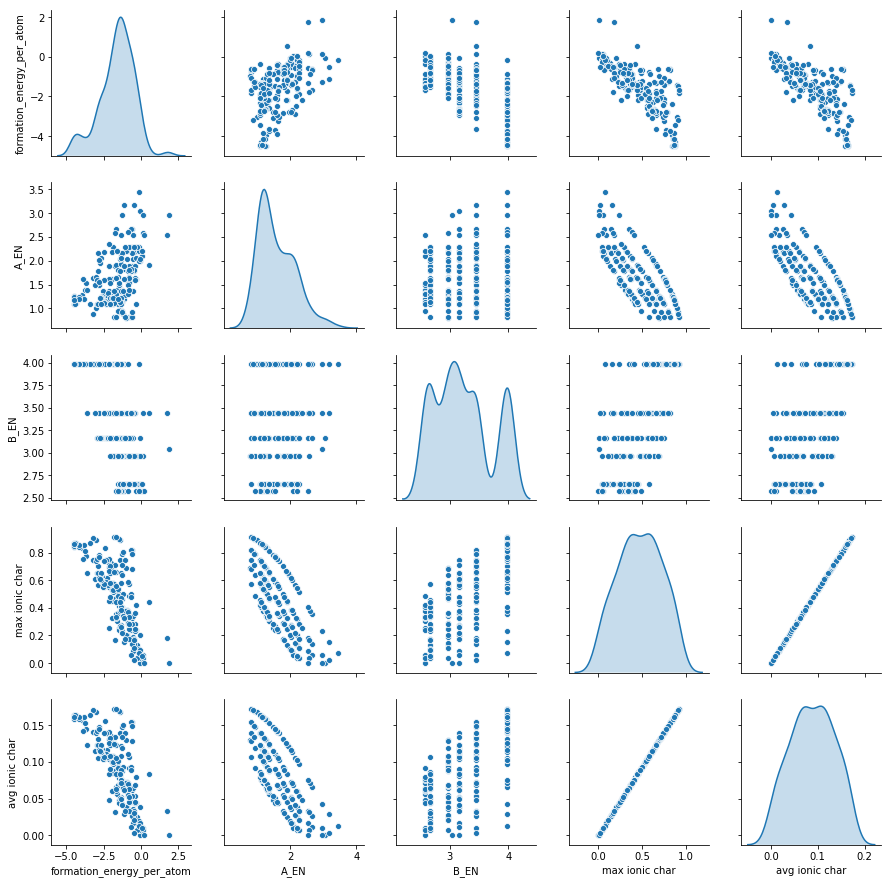

In [98]:
sns.pairplot(train_dataset[['formation_energy_per_atom', 'A_EN', 'B_EN', 'max ionic char',
       'avg ionic char']], diag_kind="kde")

#### 数据统计

In [99]:
train_stats = train_dataset.describe()
train_stats.pop("formation_energy_per_atom")   #拿开formation_energy_per_atom这一列
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
A_EN,222.0,1.604955,0.540176,0.790000,1.200000,1.500000,2.015000,3.440000
B_EN,222.0,3.238559,0.478200,2.580000,2.960000,3.160000,3.440000,3.980000
max ionic char,222.0,0.473621,0.244308,0.000225,0.285663,0.474815,0.653856,0.917619
avg ionic char,222.0,0.088804,0.045808,0.000042,0.053562,0.089028,0.122598,0.172054


#### 将预测的目标从测试集和训练集中拿走

In [100]:
train_labels = train_dataset.pop('formation_energy_per_atom')
test_labels = test_dataset.pop('formation_energy_per_atom')

#### 标准化数据

In [101]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#### 构建模型

In [125]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [126]:
model = build_model()

####  查看模型情况

In [127]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


#### 用一批含有十组数据的样本对模型进行测试

In [128]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.18635944],
       [-0.09391823],
       [-0.19828708],
       [-0.37094373],
       [-0.04355197],
       [-0.04130791],
       [-0.05317409],
       [-0.20416637],
       [-0.18158954],
       [-0.16187227]], dtype=float32)

#### 对模型训练1000次，记录下训练和验证的精度

In [129]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

#### 查看不同次数下的训练状态

In [130]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.191223,0.287325,0.191223,0.143417,0.293205,0.143417,995
996,0.188269,0.280150,0.188269,0.132551,0.277078,0.132551,996
997,0.188032,0.282247,0.188032,0.135458,0.285990,0.135458,997
998,0.190166,0.287885,0.190166,0.136324,0.278899,0.136324,998
999,0.190898,0.277381,0.190898,0.132447,0.277775,0.132447,999


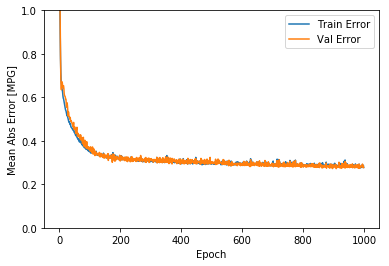

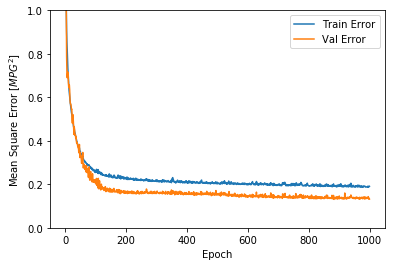

In [131]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()
  plt.show()


plot_history(history)

#### 更改模型，当训练过程中验证集效果不再提升时自动停止训练


....................................................................................................
......................................................................................

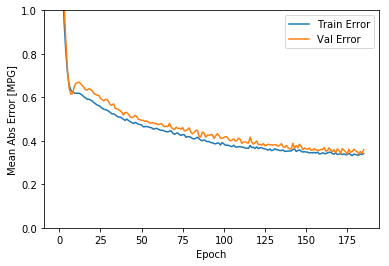

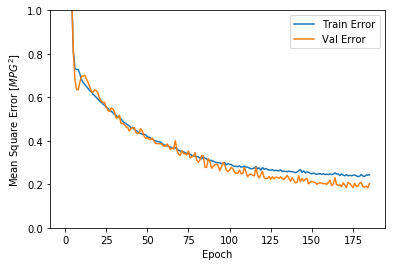

In [132]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [133]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} formation_energy_per_atom".format(mae))

Testing set Mean Abs Error:  0.37 formation_energy_per_atom


#### 进行预测

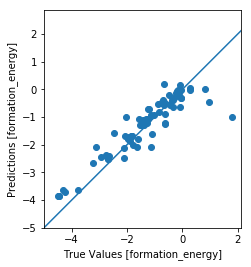

In [134]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [formation_energy]')
plt.ylabel('Predictions [formation_energy]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-5,plt.xlim()[1]])
plt.ylim([-5,plt.ylim()[1]])
_ = plt.plot([-100,100 ], [-100, 100])

#### 查看误差分布

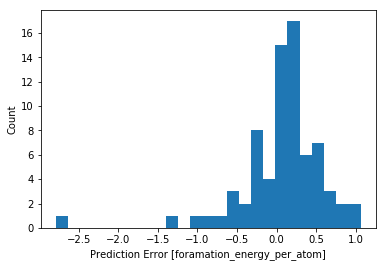

In [135]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [foramation_energy_per_atom]")
_ = plt.ylabel("Count")